### Import libraries

In [71]:
import pandas as pd
import numpy as np
import os
from datetime import timedelta
import sqlite3

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer

import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc, roc_auc_score

pd.options.display.max_rows = 10
pd.options.display.max_columns = 100

### Load inputs

In [72]:
patient_profile = pd.read_csv('Train/Patient_Profile.csv')
camp_detail = pd.read_csv('Train/Health_Camp_Detail.csv')
first_camp_attended = pd.read_csv('Train/First_Health_Camp_Attended.csv')
second_camp_attended = pd.read_csv('Train/Second_Health_Camp_Attended.csv')
third_camp_attended = pd.read_csv('Train/Third_Health_Camp_Attended.csv')
train = pd.read_csv('Train/train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submmission.csv')

first_camp_attended= first_camp_attended.drop('Unnamed: 4',axis=1)

### Create response variable

In [73]:
# create response
favourable_response = (first_camp_attended[['Patient_ID','Health_Camp_ID']]
                       .append(second_camp_attended[['Patient_ID','Health_Camp_ID']])
                       .append(third_camp_attended.loc[third_camp_attended.Number_of_stall_visited > 0,['Patient_ID','Health_Camp_ID']])
                      )
favourable_response['response'] = 1

### Generate test and train datasets

#### a. Add response

In [74]:
train['flag'] = 'train'
test['flag'] = 'test'
all_obs = train.append(test)

# join with patient profile, all patients in test and train have profiles
all_obs = all_obs.merge(patient_profile,on = 'Patient_ID',how = 'inner')

# join with camp_detail
all_obs = all_obs.merge(camp_detail, on= 'Health_Camp_ID',how = 'inner')

# add response
all_obs = all_obs.merge(favourable_response, on = ['Patient_ID','Health_Camp_ID'],how = 'left')
all_obs.loc[all_obs.response.isna(),'response'] = 0
all_obs.response = all_obs.response.astype('int')

#### b. Time related features

In [75]:
# convert dates to proper format
all_obs.Registration_Date = pd.to_datetime(all_obs.Registration_Date,format ='%d-%b-%y')
all_obs.First_Interaction = pd.to_datetime(all_obs.First_Interaction,format ='%d-%b-%y')
all_obs.Camp_Start_Date = pd.to_datetime(all_obs.Camp_Start_Date,format ='%d-%b-%y')
all_obs.Camp_End_Date = pd.to_datetime(all_obs.Camp_End_Date,format ='%d-%b-%y')

# camp duration
all_obs['camp_duration'] = (all_obs.Camp_End_Date - all_obs.Camp_Start_Date).dt.days

# Date imputation
all_obs.loc[all_obs.Registration_Date.isna(),'Registration_Date'] = (all_obs.Camp_Start_Date + 
                                                                     pd.to_timedelta(all_obs.camp_duration/2,unit = 'D'))


all_obs = all_obs.sort_values(['Patient_ID','Registration_Date'])

# If patient registered before camp started
all_obs['registered_before_camp_start'] = (all_obs.Registration_Date< all_obs.Camp_Start_Date).astype('int')

# How many days of camp is left after registration
all_obs['days_left_campEnd'] = (all_obs['Camp_End_Date'] - all_obs['Registration_Date']).dt.days

# how much of camp has elapsed as of registration time (fraction)
all_obs['elapsed_camp'] = 1 - (all_obs['days_left_campEnd']/ all_obs['camp_duration'])
all_obs.loc[all_obs['elapsed_camp']<0,'elapsed_camp'] = 0

# Get last interaction date for a patient
reg_by_patient = all_obs[['Patient_ID','Registration_Date']].drop_duplicates().sort_values(['Patient_ID','Registration_Date'])
reg_by_patient['Last_interaction'] = reg_by_patient.groupby('Patient_ID').shift()
all_obs = all_obs.merge(reg_by_patient, on = ['Patient_ID','Registration_Date'])

# days since last interaction / registration
all_obs.loc[all_obs['Last_interaction'].isna(),'Last_interaction'] = all_obs.First_Interaction
all_obs['days_since_last_interaction'] = (all_obs.Registration_Date - all_obs.Last_interaction).dt.days

# days since first interaction
all_obs['days_since_first_interaction'] = (all_obs.Registration_Date - all_obs.First_Interaction).dt.days

# count of camps registered by a patient on each date
all_obs['same_day_reg_count'] = all_obs.groupby(['Registration_Date','Patient_ID'])['Health_Camp_ID'].transform('count')

# split date
all_obs['weekday']= all_obs.Registration_Date.dt.weekday
all_obs['year'] = all_obs.Registration_Date.dt.year
all_obs['month'] = all_obs.Registration_Date.dt.month

#### c. OnehotEncode categorical

In [76]:
# #one hot encoding for categorical / others are not important
all_obs = all_obs.join(pd.get_dummies(all_obs.Category1))
all_obs = all_obs.join(pd.get_dummies(all_obs.Category2))

#### d. Anonymized variables

In [77]:
# anonymized variables
all_obs['var1_to_var2'] = all_obs['Var1']/all_obs['Var2']
all_obs.loc[(all_obs['var1_to_var2'].isna()) & (all_obs['Var1']>0) ,'var1_to_var2'] = 1
all_obs.loc[all_obs['var1_to_var2'].isna(),'var1_to_var2'] = 0

all_obs.loc[all_obs.Var1>0,'Var1']=1
all_obs.loc[all_obs.Var2>0,'Var2']=1
all_obs.loc[all_obs.Var4>0,'Var4']=1

#### e. Patient history features

In [78]:
patient_history = (all_obs[['Patient_ID','Health_Camp_ID','Registration_Date','Category1','response']]
                       .merge(first_camp_attended, on = ['Patient_ID','Health_Camp_ID'],how = 'left')
                       .merge(second_camp_attended, on = ['Patient_ID','Health_Camp_ID'],how = 'left')
                       .merge(third_camp_attended, on = ['Patient_ID','Health_Camp_ID'],how = 'left'))

patient_history = patient_history.fillna(0)


import sqlite3
#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
patient_history.to_sql('patient_history', conn, index=False)
qry = '''
        select a.Patient_ID, a.Registration_Date, 
        count(b.Health_Camp_ID) as prev_registration_count,
        sum(b.response) / count(b.Health_Camp_ID) as prev_response_rate,
        (sum(case when b.Category1 = 'First' then b.response else NULL end) / 
        count( case when b.Category1 = 'First' then b.Health_Camp_ID else NULL end)) as prev_first_response_rate,
        (sum(case when b.Category1 = 'Second' then b.response else NULL end) / 
        count( case when b.Category1 = 'Second' then b.Health_Camp_ID else NULL end)) as prev_second_response_rate,
        (sum(case when b.Category1 = 'Third' then b.response else NULL end) / 
        count( case when b.Category1 = 'Third' then b.Health_Camp_ID else NULL end)) as prev_third_response_rate,
        sum(b.Donation) as prev_donation,
        avg(case when b.Category1 = 'First' then b.Donation else NULL end) as prev_donation_avg,
        avg(case when b.Category1 = 'First' then b.Health_Score else NULL end ) as prev_avg_health_score1,
        avg(case when b.Category1 = 'Second' then b.[Health Score] else NULL end ) as prev_avg_health_score2,
        sum(b.Number_of_stall_visited) as prev_stall_count,
        avg(case when b.Category1 = 'Third' then b.Number_of_stall_visited else NULL end) as prev_stall_count_avg,
        count(distinct b.Last_Stall_Visited_Number) as prev_distinct_stalls
        from patient_history as a left join patient_history as b
        on a.Patient_ID = b.Patient_ID
        and b.Registration_Date < a.Registration_Date
        group by a.Patient_ID, a.Registration_Date
        
      '''
patient_history = pd.read_sql_query(qry, conn)


all_obs['Registration_Date_Key'] = all_obs.Registration_Date.astype('str')
patient_history['Registration_Date_Key'] = patient_history.Registration_Date.astype('str')


all_obs = (all_obs.merge(patient_history.drop('Registration_Date',axis = 1),
                         on = ['Patient_ID','Registration_Date_Key'],
                         how = 'left').drop('Registration_Date_Key',axis =1))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:2531: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype, method=method)


#### f. Impute missing values

In [79]:
from sklearn.impute import SimpleImputer

all_obs.loc[all_obs.Education_Score == 'None','Education_Score'] = None
all_obs.Education_Score = all_obs.Education_Score.astype('float')

all_obs.loc[all_obs.Age == 'None','Age'] = None
all_obs.Age = all_obs.Age.astype('float')

all_obs.loc[all_obs.Income == 'None','Income'] = None
all_obs.Income = all_obs.Income.astype('float')


imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(all_obs[['Age','Education_Score','Income']])
all_obs[['Age','Education_Score','Income']] = imp_mean.transform(all_obs[['Age','Education_Score','Income']])


#### g. Scale Features

In [ ]:
train_final_data = all_obs.loc[all_obs.flag == 'train',:]
test_final_data = all_obs.loc[all_obs.flag == 'test',:]

scalable_cols = ['Income','Age','Education_Score','camp_duration','days_left_campEnd',
                 'days_since_last_interaction','days_since_first_interaction','prev_registration_count',
                 'prev_donation', 'prev_donation_avg','prev_stall_count','prev_stall_count_avg','prev_distinct_stalls']

for col in train_final_data.columns:
    if (col in scalable_cols) :
        mms = MinMaxScaler()
        ss = StandardScaler()
        rs = RobustScaler()
        pt = PowerTransformer()
        ft_log = FunctionTransformer(np.log)

        new_col = col+ '_MMS'
        train_final_data[new_col] = mms.fit_transform(train_final_data[[col]])
        test_final_data[new_col] = mms.transform(test_final_data[[col]])

        train_final_data[f"{col}_SS"] = ss.fit_transform(train_final_data[[col]])
        test_final_data[f"{col}_SS"] = ss.transform(test_final_data[[col]])

        train_final_data[f"{col}_RS"] = rs.fit_transform(train_final_data[[col]])
        test_final_data[f"{col}_RS"] = rs.transform(test_final_data[[col]])

        train_final_data[f"{col}_PT"] = pt.fit_transform(train_final_data[[col]])
        test_final_data[f"{col}_PT"] = pt.transform(test_final_data[[col]])

all_obs = pd.concat([train_final_data,test_final_data])

### Model

#### a. Split data

In [80]:
# exclude these from features
exclusions = (['Patient_ID','Health_Camp_ID','Registration_Date','flag','First_Interaction',
               'City_Type','Employer_Category','Camp_Start_Date','Camp_End_Date', 'Category1',
               'Category2', 'Last_interaction',
               'response'])

# response = 'response'

train_set = all_obs.loc[all_obs.flag == 'train',:]

test_set = all_obs.loc[all_obs.flag == 'test',:]

np.random.seed(999)

train_set.loc[:,'holdout'] = np.random.random((len(train_set.index)))

train_set.loc[train_set['holdout']>0.75,'holdout'] = 1
train_set.loc[train_set['holdout']<1,'holdout'] = 0

train_set_ = train_set.loc[train_set.holdout==0,:].drop('holdout',axis =1 )
print(train_set_.shape)

holdout = train_set.loc[train_set.holdout==1,:].drop('holdout',axis =1 )
print(holdout.shape)

train_set = train_set.drop('holdout',axis =1 )
print(train_set.shape)

# Use these for CV
X_train_ = train_set.drop( exclusions,axis=1)
Y_train_ = train_set['response']

# Use these for final model
X_train, X_validate, Y_train, Y_validate = train_test_split(train_set_.drop( exclusions,axis=1),
                                                    train_set_['response'], test_size=0.25,random_state = 1)

# Unseen
X_holdout = holdout.drop(exclusions,axis =1)
Y_holdout = holdout['response']

# # split by time?
# X_train = train_set.loc[train_set.Camp_Start_Date < '2005-07-01',:].drop(exclusions,axis =1)
# Y_train = train_set.loc[train_set.Camp_Start_Date < '2005-07-01','response']
# X_validate = train_set.loc[train_set.Camp_Start_Date > '2005-07-01',:].drop(exclusions,axis =1)
# Y_validate = train_set.loc[train_set.Camp_Start_Date > '2005-07-01','response']

# D_train = xgb.DMatrix(X_train, label=Y_train)
# D_validate = xgb.DMatrix(X_validate, label=Y_validate)
# D_holdout = xgb.DMatrix(X_holdout,label = Y_holdout)

print(X_train.shape)
print(X_validate.shape)
print(X_holdout.shape)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(56398, 59)
(18880, 59)
(75278, 59)
(42298, 46)
(14100, 46)
(18880, 46)


#### b. Fit model

In [81]:
param = {
    'learning_rate': 0.05, 
    'max_depth': 5,  
    'colsample_bytree': 1,
    'subsample': 0.75,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'verbosity': 1,
    'random_state': 0,
    'n_estimators' : 3000
    } 


feature_names = list(X_train.columns)

classifier = xgb.XGBClassifier(**param)

classifier.fit(X_train,Y_train, eval_set=[(X_validate, Y_validate)],
               eval_metric=['logloss','auc'],
               early_stopping_rounds = 50,
               verbose=50)

# xgb_booster = xgb.train(param, D_train, steps,early_stopping_rounds = 50, verbose_eval = 50,
#                            evals = [(D_train,'train'),(D_validate,'eval')])

preds_validate = classifier.get_booster().predict(xgb.DMatrix(X_validate))
preds_holdout = classifier.get_booster().predict(xgb.DMatrix(X_holdout))

print("Validation AUC - "+ str(roc_auc_score(Y_validate,preds_validate)))
print("holdout AUC - "+ str(roc_auc_score(Y_holdout,preds_holdout)))


[0]	validation_0-logloss:0.66996	validation_0-auc:0.83609
Multiple eval metrics have been passed: 'validation_0-auc' will be used for early stopping.

Will train until validation_0-auc hasn't improved in 50 rounds.
[50]	validation_0-logloss:0.41047	validation_0-auc:0.85810
[100]	validation_0-logloss:0.39575	validation_0-auc:0.86604
[150]	validation_0-logloss:0.39097	validation_0-auc:0.86932
[200]	validation_0-logloss:0.38887	validation_0-auc:0.87065
[250]	validation_0-logloss:0.38760	validation_0-auc:0.87138
[300]	validation_0-logloss:0.38658	validation_0-auc:0.87204
[350]	validation_0-logloss:0.38607	validation_0-auc:0.87235
[400]	validation_0-logloss:0.38536	validation_0-auc:0.87288
[450]	validation_0-logloss:0.38459	validation_0-auc:0.87342
[500]	validation_0-logloss:0.38391	validation_0-auc:0.87386
[550]	validation_0-logloss:0.38351	validation_0-auc:0.87415
[600]	validation_0-logloss:0.38312	validation_0-auc:0.87445
[650]	validation_0-logloss:0.38249	validation_0-auc:0.87496
[700]	

#### c. Feature selection

In [ ]:
from sklearn.feature_selection import RFE

selector = RFE(classifier, step=1,verbose = 1)
selector.fit(X_train,Y_train)

feature_rankings = pd.DataFrame([selector.ranking_ ,np.array(X_train.columns)]).transpose()
feature_rankings.columns= ['rank','feature']
feature_rankings.sort_values('rank').reset_index()

#### d. Hyperparams tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

params = {
        'min_child_weight': [1, 5, 10],
        'max_depth': [3, 4, 5, 6, 7]
        }

random_walk = RandomizedSearchCV(classifier, param_distributions=params, n_iter=5, 
                   scoring='roc_auc',  cv=skf.split(X_train_,Y_train_), verbose=3, random_state=0 )

random_walk.fit(X_train_,Y_train_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] min_child_weight=5, max_depth=3 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... min_child_weight=5, max_depth=3, score=0.877, total= 1.2min
[CV] min_child_weight=5, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


### Model Evaluation

#### a. Feature importance

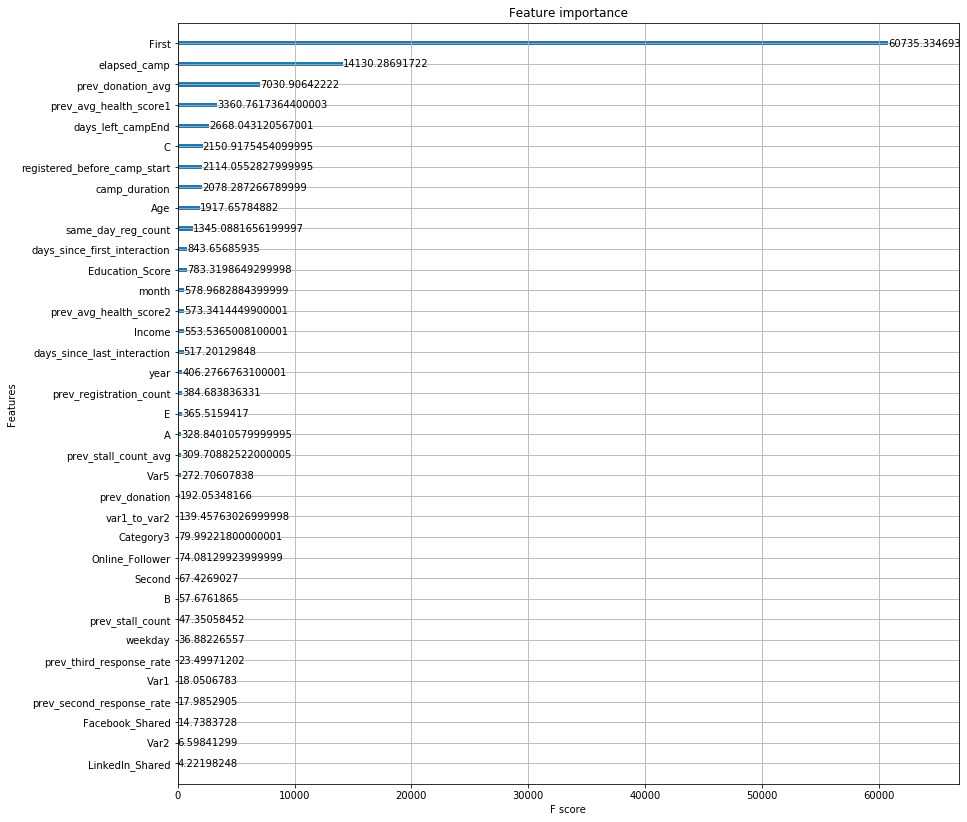

In [45]:
#feature importance
plt.rcParams["figure.figsize"] = (14, 14)
xgb.plot_importance(classifier.get_booster(),importance_type = 'total_gain')
plt.show()

In [46]:
xgb_booster = classifier.get_booster()
gains = pd.DataFrame.from_dict(xgb_booster.get_score(importance_type= 'gain'),'index',columns = ['gain'])
weight = pd.DataFrame.from_dict(xgb_booster.get_score(importance_type= 'weight'),'index',columns = ['weight'])
cover = pd.DataFrame.from_dict(xgb_booster.get_score(importance_type= 'cover'),'index',columns = ['cover'])
total_gains = pd.DataFrame.from_dict(xgb_booster.get_score(importance_type= 'total_gain'),'index',columns = ['total_gains'])
total_cover = pd.DataFrame.from_dict(xgb_booster.get_score(importance_type= 'total_cover'),'index',columns = ['total_cover'])

len(gains)

pd.options.display.max_rows = 100
feature_imp = pd.concat([gains, weight,cover, total_gains,total_cover], axis=1).sort_values('weight',ascending = False)
feature_imp

,gain,weight,cover,total_gains,total_cover
days_left_campEnd,28.084664,95,998.746878,2668.043121,94880.953421
camp_duration,26.307434,79,514.731979,2078.287267,40663.826305
elapsed_camp,181.157525,78,1113.499356,14130.286917,86852.949782
Age,24.904647,77,2007.961382,1917.657849,154613.026432
days_since_last_interaction,10.555129,49,269.061504,517.201298,13184.013695
same_day_reg_count,28.618897,47,934.967625,1345.088166,43943.478359
month,13.158370,44,333.039128,578.968288,14653.721649
prev_donation_avg,175.772661,40,2384.423119,7030.906422,95376.924773
prev_avg_health_score1,90.831398,37,1654.934524,3360.761736,61232.577393
prev_avg_health_score2,16.862984,34,370.013745,573.341445,12580.467317


#### b. Predicted vs Observed (validation)

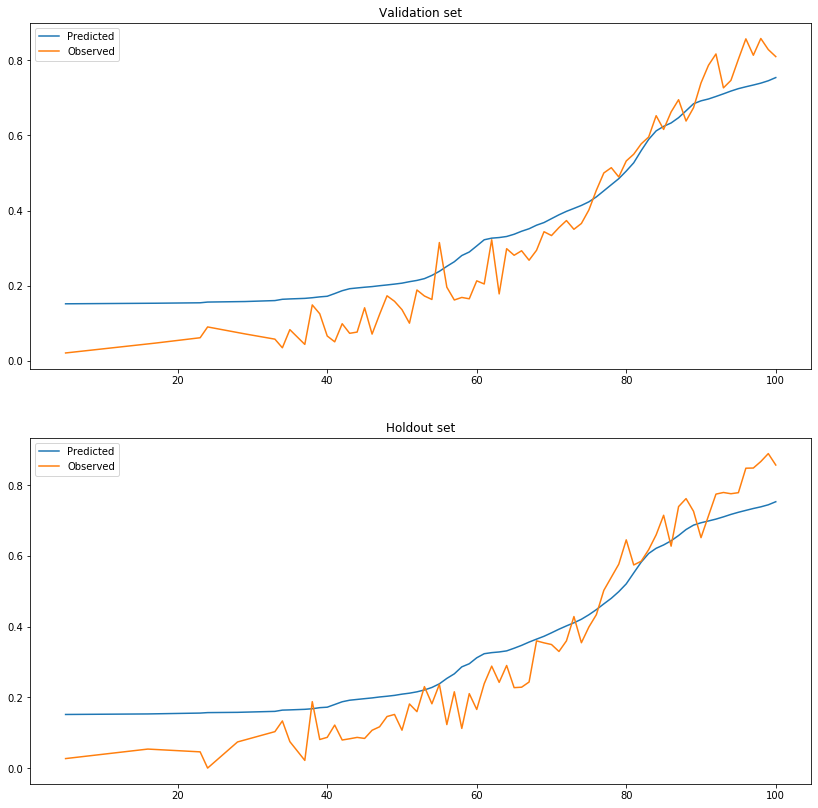

In [55]:
#pvo
def pvo(obs, pred,ax,title):
    pvo = pd.DataFrame(list(zip(obs,pred)),columns =['observed','predicted']).reset_index()
    pvo['percentile'] = np.ceil(100 * pvo.predicted.rank(ascending =True)/len(pvo.index))
    pvo = pvo.groupby(['percentile'])['observed','predicted'].mean().reset_index()
    ax.plot(pvo.percentile,pvo.predicted, label = 'Predicted')
    ax.plot(pvo.percentile,pvo.observed, label = 'Observed')
    ax.legend(loc = 'upper left')
    ax.set_title(title)

#pdp
fig,[ax1, ax2] = plt.subplots(ncols = 1, nrows = 2,figsize=(14,14))
pvo(Y_validate,preds_validate,ax1,'Validation set')
pvo(Y_holdout,preds_holdout,ax2,'Holdout set')

#### c. ROC

AUC (valid) = 0.8523433768620126
AUC (holdout) = 0.8526711515586701


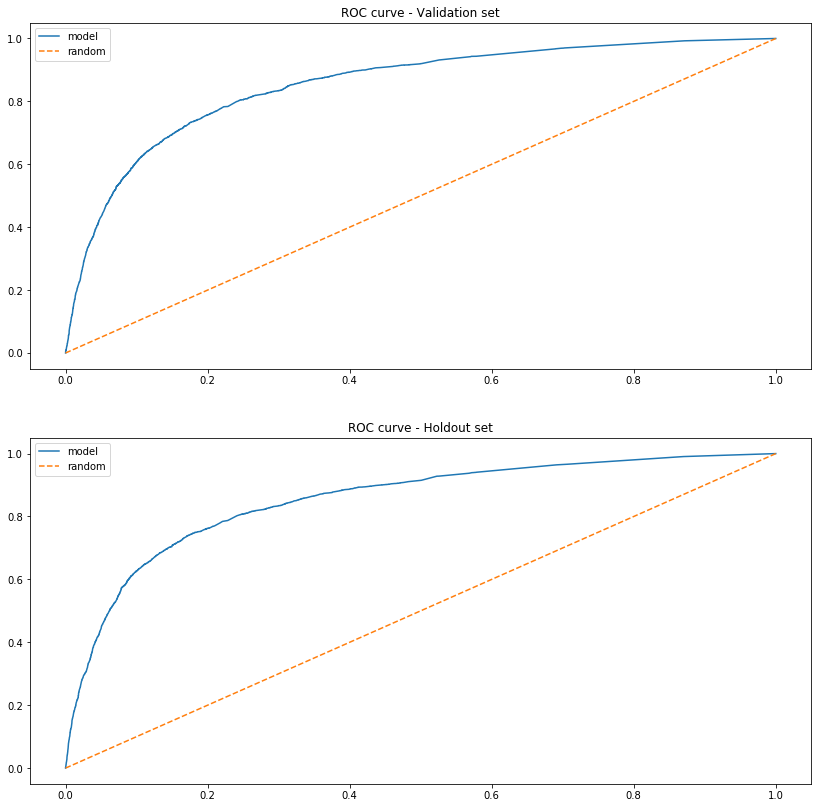

In [59]:
print("AUC (valid) = " + str(roc_auc_score(Y_validate,preds_validate)))
print("AUC (holdout) = " + str(roc_auc_score(Y_holdout,preds_holdout)))

fig,[ax1, ax2] = plt.subplots(ncols = 1, nrows = 2,figsize=(14,14))

fpr, tpr, thresholds = roc_curve(Y_validate,preds_validate)

ax1.plot(fpr,tpr, label = 'model')
ax1.plot([0,1],[0,1], label = 'random',linestyle='--')
ax1.set_title('ROC curve - Validation set')
ax1.legend(loc = 'upper left')

fpr, tpr, thresholds = roc_curve(Y_holdout,preds_holdout)

ax2.plot(fpr,tpr, label = 'model')
ax2.plot([0,1],[0,1], label = 'random',linestyle='--')
ax2.set_title('ROC curve - Holdout set')
ax2.legend(loc = 'upper left')
plt.show()

### Score and submit

In [154]:
#retrain on whole data

X_train = train_set.drop(exclusions,axis =1)
Y_train = train_set[['response']]


X_test = test_set.drop( exclusions,axis=1)


param = {
    'learning_rate': 0.05, 
    'max_depth': 5,  
    'colsample_bytree': 1,
    'subsample': 0.75,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'verbosity': 1,
    'random_state': 0,
    'n_estimators' : 30
    } 


feature_names = list(X_train.columns)

classifier = xgb.XGBClassifier(**param)

classifier.fit(X_train,Y_train, eval_metric=['logloss','auc'],
               early_stopping_rounds = 50,
               verbose=50)


# model = xgb.train(param, D_train, steps)


#score test
submission = test_set.loc[:,['Patient_ID','Health_Camp_ID']]
submission['Outcome'] = classifier.get_booster().predict(X_test)
# submission = sample_sub[['Patient_ID','Health_Camp_ID']].merge(submission,on = ['Patient_ID','Health_Camp_ID'])

# scored submission
submission.to_csv('submission.csv',index =False)